In [553]:
import time
import scipy.stats as stats
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

sys.path.append('..\..')

from simple_network_sim import data
from simple_network_sim import network_of_populations as ss
from simple_network_sim import loaders
from simple_network_sim.sampleUseOfModel import runSimulation, aggregateResults

with data.Datastore("../../config_inference.yaml") as store:
    network = ss.createNetworkOfPopulation(
        store.read_table("human/compartment-transition"),
        store.read_table("human/population"),
        store.read_table("human/commutes"),
        store.read_table("human/mixing-matrix"),
        store.read_table("human/infectious-compartments"),
#         store.read_table("human/infection-probability"),
        pd.DataFrame([0., 0.06], columns=[0], index=["Time", "Value"]).T,
        store.read_table("human/initial-infections"),
        store.read_table("human/trials"),
        store.read_table("human/start-date"),
        store.read_table("human/movement-multipliers"),
        store.read_table("human/stochastic-mode"),
        store.read_table("human/random-seed"),
    )
    
def aggregate_all_boards(results):
    return results.groupby(["date", "state"]).sum().reset_index().pivot(index="date", columns="state", values="total")

# Target

Generated from the production model, we will try to fit infection probability to it.

164640

In [554]:
results = runSimulation(network, 111)
result = aggregateResults(results)
target = aggregate_all_boards(result)

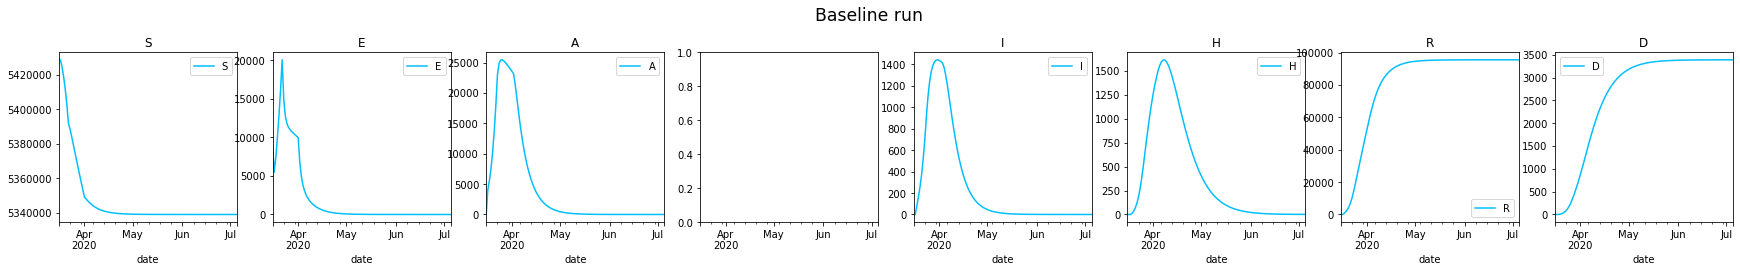

In [555]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(30, 3.5), sharex=True)
fig.suptitle(f"Baseline run", fontsize='xx-large')
fig.subplots_adjust(top=0.8)
for i, col in enumerate(['S', 'E', 'A', 'A_2', 'I', 'H', 'R', 'D']):
    try:
        target[col].plot(ax=axes[i], title=col, c="deepskyblue")
        axes[i].legend()
    except:
        pass

## Deaths by week and HB

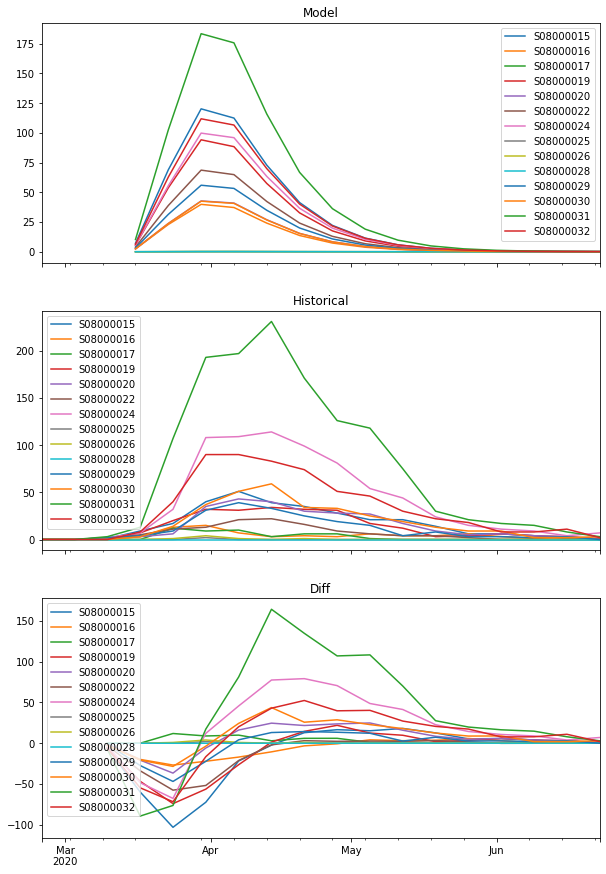

In [556]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15), sharex=True)

result_by_node = (
    result
    .query("state == 'D'")
    .groupby(["date", "node"])
    .sum()
    .reset_index()
    .pivot(index="date", columns="node", values="total")
    .diff()
    .resample('7D').sum()
    
)
result_by_node.index.name = None
result_by_node.columns.name = None
result_by_node = result_by_node.reindex(sorted(result_by_node.columns), axis=1)
result_by_node.plot(ax=axes[0], title="Model")

historical = store.read_table("human/historical-deaths").set_index("Week beginning")
historical.index = pd.to_datetime(historical.index)
historical = historical.loc["2020-03-02":]
historical.index.name = None
historical = historical.reindex(sorted(historical.columns), axis=1)
historical.plot(ax=axes[1], title="Historical")

(historical - result_by_node).plot(ax=axes[2], title="Diff");

In [31]:
with data.Datastore("../../config.yaml") as store:
    df = store.read_table("human/compartment-transition")
pd.pivot_table(df, values="rate", index="dst", columns=["age", "src"]).style.set_precision(2).background_gradient("Reds", high=0.5).highlight_null("black")

C:\Users\gorokf\.conda\envs\simple_network_sim\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


In [32]:
with data.Datastore("../../config_inference.yaml") as store:
    df = store.read_table("human/compartment-transition")
pd.pivot_table(df, values="rate", index="dst", columns=["age", "src"]).style.set_precision(2).background_gradient("Reds", high=0.5).highlight_null("black")

# Priors

Prior on infection probability. Beta distribution with well chosen parameters to be fairly highly concentrated around known value.

In [41]:
def generate_random_infection_probability(location=4, mean=0.05):
    return pd.DataFrame([0., np.random.beta(location, location * (1 - mean) / mean)], columns=[0], index=["Time", "Value"]).T

In [540]:
location = 4
mean = 0.05
np.mean(np.random.beta(location, location * (1 - mean) / mean, 100000))

0.04995121593987165

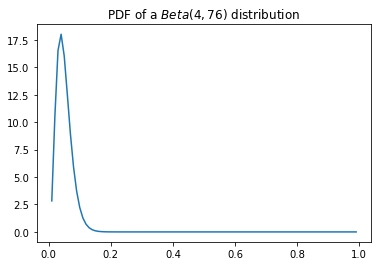

In [541]:
from scipy.stats import beta
x = np.arange (0.01, 1, 0.01)
y = beta.pdf(x, location, location * (1 - mean) / mean)
plt.plot(x, y);
plt.title(f"PDF of a $Beta({location}, {location * (1 - mean) / mean:.0f})$ distribution");

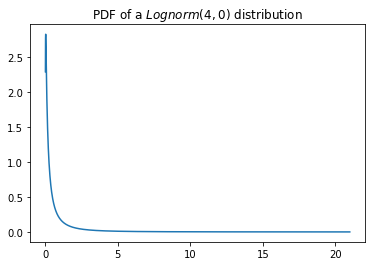

In [544]:
from scipy.stats import lognorm

mean = 1.
var = 10.
sigma = np.sqrt(np.log(1 + (var / mean**2)))
mu = np.log(mean / np.sqrt(1 + (var / mean**2)))

x = np.arange (0.01, mean + 2 * var, 0.01)
y = lognorm(s=sigma, loc=0., scale=np.exp(mu)).pdf(x)
plt.plot(x, y);
plt.title(f"PDF of a $Lognorm({location}, {location * (1 - mean) / mean:.0f})$ distribution");

# ABC SMC

As per the original paper (https://royalsocietypublishing.org/doi/pdf/10.1098/rsif.2008.0172) the error function used to compare two models is simply the root mean sum of squares of differences between the deaths time series (the only fully reliable number available).

In [69]:
def generate_random_infection_probability(location=4, mean=0.05):
    return np.random.beta(location, location * (1 - mean) / mean)


def generate_particle_from_priors():
    return {
        "infection-probability": generate_random_infection_probability(),
    }


def sample_from_particles(particles, weights):
    return np.random.choice(particles, p=weights / np.sum(weights))


def perturbation_kernel(sigma=0.1):
    return np.random.uniform(-1, 1) * sigma


def perturb_particle(particle):
    return {
        "infection-probability": particle["infection-probability"] + perturbation_kernel(),
    }


def validate_particle(particle):
    success = True
    success &= (0 < particle["infection-probability"] < 1)
    return success


def generate_perturbated_particle(particles, weights):
    while True:
        particle = sample_from_particles(particles, weights)
        particle = perturb_particle(particle)
        
        if validate_particle(particle):
            return particle

        
def rmse(y, y_hat):
    return np.sqrt(np.mean((y.D.values - y_hat.D.values)**2))
        

def run_model(particle):
    network = ss.createNetworkOfPopulation(
        store.read_table("human/compartment-transition"),
        store.read_table("human/population"),
        store.read_table("human/commutes"),
        store.read_table("human/mixing-matrix"),
        store.read_table("human/infectious-compartments"),
        pd.DataFrame([0., particle["infection-probability"]], columns=[0], index=["Time", "Value"]).T,
        store.read_table("human/initial-infections"),
        store.read_table("human/trials"),
        store.read_table("human/movement-multipliers"),
        store.read_table("human/stochastic-mode"),
        store.read_table("human/random-seed"),
    )
    results = runSimulation(network, 200)
    return aggregate_all_boards(aggregateResults(results))


def compute_weights(smc_step, particles, weights, particle):
    if smc_step == 0:
        return 1.
    else:
        denom = 0.
        for i, p in enumerate(particles):
            denom += weights[i] * 0.5
        
        return stats.beta(location, location * (1 - mean) / mean).pdf(particle["infection-probability"]) / denom

In [70]:
n_smc_steps = 5
n_sim_steps = 1e6
n_particles = 5
smc_tolerances = [100, 75, 50, 25, 10]

prev_particles = []
prev_weights = []

for smc_step in range(n_smc_steps):
    print(f"SMC step {smc_step + 1}/{n_smc_steps}")
    
    particles = []
    weights = []
    particles_accepted = 0
    particles_simulated = 0
    while particles_accepted < n_particles:
            
        if smc_step == 0:
            particle = generate_particle_from_priors()
        else:
            particle = generate_perturbated_particle(prev_particles, prev_weights)
            
        result = run_model(particle)
        distance = rmse(target, result)
        
        if distance <= smc_tolerances[smc_step]:
            print(f"Particle accepted with distance {distance}")
            weight = compute_weights(smc_step, prev_particles, prev_weights, particle)
            particles.append(particle)
            weights.append(weight)
            particles_accepted += 1
            
        particles_simulated += 1
            
    print(f"Particles accepted {particles_accepted}/{particles_simulated}")
    prev_particles = particles
    prev_weights = weights

SMC step 1/5
Particle accepted with distance 73.504647614871
Particle accepted with distance 71.14904585263787
Particle accepted with distance 73.58758622299351
Particle accepted with distance 73.09832156101398
Particle accepted with distance 65.70532569725917
Particles accepted 5/5
SMC step 2/5
Particle accepted with distance 63.631756128885925
Particle accepted with distance 64.34279359318263
Particle accepted with distance 59.41639762281992
Particle accepted with distance 71.30287289181898
Particle accepted with distance 63.80151870414818
Particles accepted 5/6
SMC step 3/5
Particle accepted with distance 43.77461872441226
Particle accepted with distance 43.763617408230125
Particle accepted with distance 42.57744094533084
Particle accepted with distance 47.47846978140427
Particle accepted with distance 44.03826918650291
Particles accepted 5/17
SMC step 4/5
Particle accepted with distance 5.401960368040804
Particle accepted with distance 18.498318343092553
Particle accepted with dist

In [71]:
particles

[{'infection-probability': 0.30388679721800976},
 {'infection-probability': 0.307595786320718},
 {'infection-probability': 0.29796330074389876},
 {'infection-probability': 0.2835113877352827},
 {'infection-probability': 0.28554897998819057}]

In [72]:
weights

[2.251733650773022,
 2.233510140655564,
 2.2779073643212495,
 2.3254386697420077,
 2.3202152465016828]